<a href="https://colab.research.google.com/github/Jerry6coding/Docs/blob/main/NLP_Twitter_disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [3]:
# !pip3 install tensorflow_text>=2.0.0rc0

In [4]:
!pip install bert-tensorflow==1.0.1

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.gfile = tf.io.gfile

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import bert
from bert import tokenization

In [6]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [7]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
#     out = tf.keras.layers.Dense(5, activation='softmax')(net)

    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 10.3 s, sys: 1.93 s, total: 12.3 s
Wall time: 12.4 s


In [9]:
train = pd.read_csv("/content/drive/MyDrive/ML_data/NLP Twitter disaster/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ML_data/NLP Twitter disaster/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/ML_data/NLP Twitter disaster/sample_submission.csv")

In [10]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [11]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [12]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

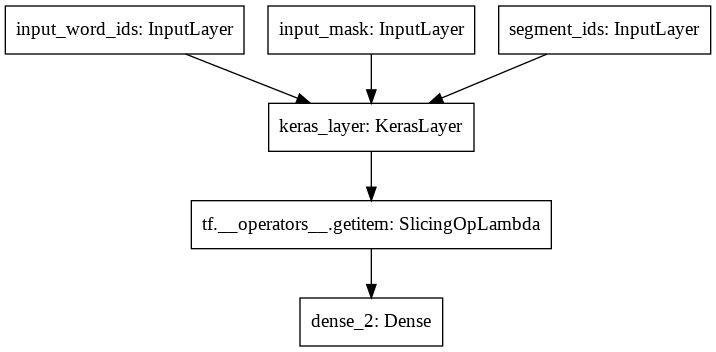

In [13]:
tf.keras.utils.plot_model(model)

In [30]:
from datetime import datetime
import os
SEED = 2
from numpy.random import seed
seed(SEED)
EPOCHS = 5
# import tensorflow as tf
tf.random.set_seed(SEED)

checkpoint_filepath_dir = "/content/drive/MyDrive/ML_data/NLP Twitter disaster/saved_models"
checkpoint_filepath = os.path.join(checkpoint_filepath_dir, "weights.h5") # saved weights
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

ModelPath = os.path.join(checkpoint_filepath_dir, "model2.h5")
model.save(ModelPath)

# # Define the Keras TensorBoard callback.
# proj_dir = "/content/drive/MyDrive/ML_data/NLP_test/"
# LogDir = proj_dir + "logs/BERT/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tb_callback = tf.keras.callbacks.TensorBoard(LogDir, histogram_freq=1)
SavedLogPath = os.path.join(checkpoint_filepath_dir, "training.log")
csv_logger = tf.keras.callbacks.CSVLogger(SavedLogPath)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystopping, csv_logger],
    batch_size=12
)

Epoch 1/5
508/508 [==============================] - 226s 421ms/step - loss: 0.1391 - accuracy: 0.9506 - val_loss: 0.5499 - val_accuracy: 0.8267
Epoch 2/5
508/508 [==============================] - 212s 417ms/step - loss: 0.0847 - accuracy: 0.9688 - val_loss: 0.6452 - val_accuracy: 0.8221
Epoch 3/5
508/508 [==============================] - 212s 417ms/step - loss: 0.0635 - accuracy: 0.9721 - val_loss: 0.8428 - val_accuracy: 0.8168
Epoch 4/5
508/508 [==============================] - 212s 417ms/step - loss: 0.0521 - accuracy: 0.9800 - val_loss: 0.8556 - val_accuracy: 0.8352
Epoch 5/5
508/508 [==============================] - 212s 417ms/step - loss: 0.0484 - accuracy: 0.9818 - val_loss: 0.7144 - val_accuracy: 0.8299


In [31]:
import pandas as pd
log_data = pd.read_csv(SavedLogPath, sep=',', engine='python')
log_data

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.950575,0.139088,0.826658,0.549913
1,1,0.968801,0.084685,0.822062,0.645169
2,2,0.972085,0.063491,0.816809,0.842819
3,3,0.979967,0.052057,0.835194,0.855570
4,4,0.981773,0.048357,0.829941,0.714403


Text(0.5, 0, 'No. epoch')

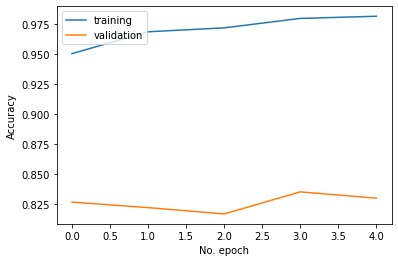

In [33]:
import matplotlib.pyplot as plt

# visualizing losses and accuracy
train_loss = log_data['loss']
val_loss   = log_data['val_loss']
train_acc  = log_data['accuracy']
val_acc    = log_data['val_accuracy']
xc         = range(5)

plt.figure()
plt.plot(xc, train_acc, label = 'training')
plt.plot(xc, val_acc, label = 'validation')
plt.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')

In [34]:
# tf.compat.v1.compat
# # new_model = tf.keras.models.load_model(ModelPath)
# saved_path = '/content/drive/MyDrive/ML_data/NLP Twitter disaster/saved_models/model2.h5'
# new_model = tf.keras.models.load_model(saved_path,custom_objects={'KerasLayer':hub.KerasLayer})

new_model = build_model(bert_layer, max_len=160)
new_model.summary()
new_model.load_weights(checkpoint_filepath)
# model.load_weights('model2.h5')
test_pred = new_model.predict(test_input)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [35]:
test_pred

array([[0.11281144],
       [0.99999034],
       [0.9999778 ],
       ...,
       [0.9999604 ],
       [0.45565447],
       [0.9892469 ]], dtype=float32)

In [ ]:
# submission['target'] = test_pred.round().astype(int)
# submission.to_csv('submission.csv', index=False)

In [ ]:
# while True: pass

In [37]:
# train_input = bert_encode(train.text.values, tokenizer, max_len=160)
# test_input = bert_encode(test.text.values, tokenizer, max_len=160)
# train_labels = train.target.values
train_input

(array([[  101,  2256, 15616, ...,     0,     0,     0],
        [  101,  3224,  2543, ...,     0,     0,     0],
        [  101,  2035,  3901, ...,     0,     0,     0],
        ...,
        [  101, 23290,  1012, ...,     0,     0,     0],
        [  101,  2610, 11538, ...,     0,     0,     0],
        [  101,  1996,  6745, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [39]:
train_prob = new_model.predict(train_input)
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]



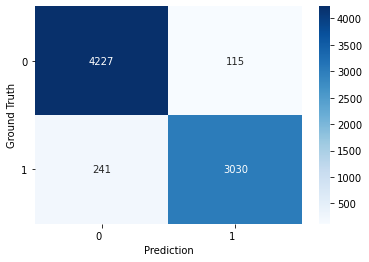

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, train_prob)
    tn, fp, fn, tp = confusion_matrix(train_labels, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('Ground Truth')
  plt.xlabel('Prediction');

y_pred_cm = train_prob.round(0)
cm = confusion_matrix(train_labels, y_pred_cm)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)



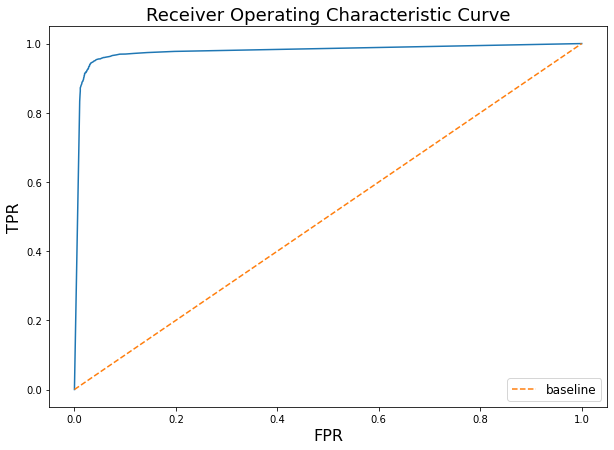

In [42]:
tpr_values, fpr_values = zip(*roc_values)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, label='ROC curve (area = %0.2f)' % roc_auc[i], c = color_list[i])
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

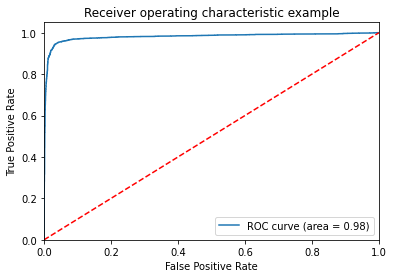

In [51]:
from sklearn.metrics import roc_curve, auc
n_classes = 1
# fpr = []
# tpr = []
# roc_auc = []
fpr, tpr, thresholds = roc_curve(train_labels, train_prob)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
color_list = ["r", "g", "b"]

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()   